In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
Dataset = CDSDataset()

def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 2.4
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        #'projection_iterations': 25, # Number of iterations into the future to project
        'projection_iterations': 80, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'case_fatality_rate': .0109341104294479,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        'incubation_period': 5, # In days
        'duration_mild_infections': 10, # In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'use_harvard_params': True, #If True use the harvard parameters directly, if not calculate off the above
        'use_harvard_init': use_harvard_init, #If True use the harvard model inputs for inital conditions and N (recreate their graph)
    }
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.35,
        datetime.date(2020, 5, 18): r0
    }
]

In [7]:
# Dataset.get_timeseries_by_country_state('USA', 'TX', 1)[['date','cases','deaths','recovered','active']]

In [8]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]


    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))
    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    return(df_plt)

In [9]:
# Params with True
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000

# params with False
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 28995881.0

In [10]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)

In [11]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

if use_harvard_init:
    df.index.name = 'date'
    df.reset_index(inplace=True)

[  1. 344.   0.   0.   0.   8.]
[0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000
                 total  susceptible  exposed  infected  infected_a  \
dt                                                                   
2020-03-18 28995881.00  28995799.00      nan     82.00           0   
2020-03-19 28995881.00  28995738.00      nan    140.00           0   
2020-03-20 28995881.00  28995687.00      nan    189.00           0   
2020-03-21 28995881.00  28995577.00      nan    299.00           0   
2020-03-22 28995881.00  28995547.00      nan    329.00           0   

            infected_b  infected_c  recovered  dead  
dt                                                   
2020-03-18           0           0       0.00  0.00  
2020-03-19           0           0       0.00  3.00  
2020-03-20           0           0       0.00  5.00  
2020-03-21           0           0       0.00  5.00  
2020-03-22           0           0    

/Users/trae/.virtualenvs/redzone/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


[ 354209.51242021   29832.36886809   94236.94661532   20694.16841587
    3292.26269251 3057231.55244368   90503.18854431]
(3650, 7)


(1, 1000)

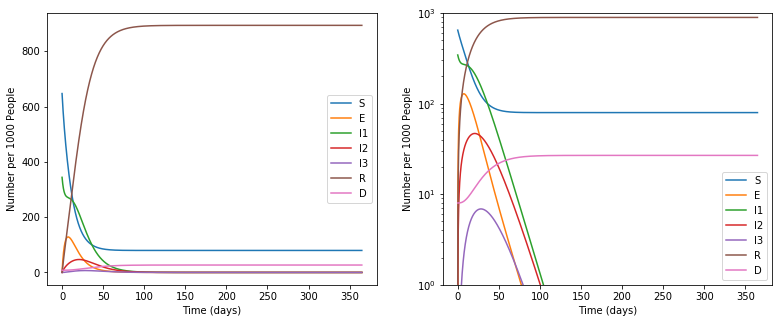

In [12]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N = 1000#28995881.00
    tvec=np.arange(0,tmax,0.1)

soln_plt = np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,N])
#plt.tight_layout()

In [10]:
df.head(25)

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,infected,total,susceptible
0,2020-03-26,10.89,1.18,0.01,0.00,0.04,0.00,1.19,1000,987.88
1,2020-03-27,8.46,2.96,0.05,0.00,0.23,0.00,3.01,1000,988.30
2,2020-03-28,8.38,4.77,0.14,0.00,0.63,0.00,4.91,1000,986.08
3,2020-03-29,7.38,5.53,0.22,0.01,1.04,0.00,5.76,1000,985.82
4,2020-03-30,8.09,7.12,0.36,0.01,1.77,0.00,7.50,1000,982.63
5,2020-03-31,7.69,7.46,0.45,0.02,2.30,0.00,7.93,1000,982.08
6,2020-04-01,8.12,8.33,0.58,0.03,3.03,0.00,8.93,1000,979.91
7,2020-04-02,9.50,10.09,0.78,0.04,4.24,0.01,10.91,1000,975.34
8,2020-04-03,9.42,10.22,0.85,0.05,4.84,0.01,11.12,1000,974.61
9,2020-04-04,11.17,12.26,1.09,0.07,6.44,0.01,13.43,1000,968.95


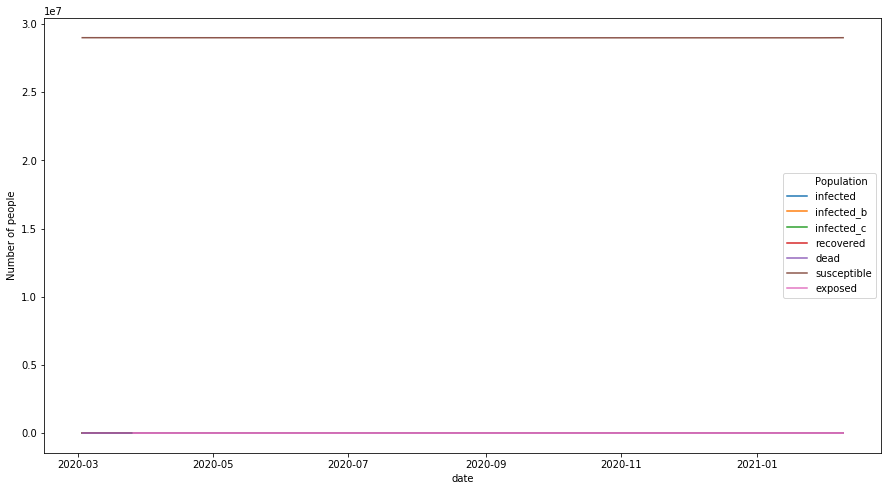

In [14]:
chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead", "susceptible"]

plot_df(df, chart_cols)